This is a notebook which combines the code from notebooks 1_Concat_scoring_method to 4_analyse_benchmark into one notebook for faster analysis. These notebooks are taken from Frappier et al. (2019) https://www.sciencedirect.com/science/article/pii/S0969212619300085

In [169]:
import glob
import re
import os
import requests
import subprocess
import copy as vcopy
import pickle
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from sklearn import metrics
import seaborn as sns

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\Python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes', 'rec', 'title', 'test', 'f', 'mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [170]:
CHAIN_LENGTH = 20

# CHANGE THESE
ETAB_FOLDER = "../../frappier_finetune_np/ingraham/ingraham_condensed/*.etab.npy"
FILE_SUFFIX = "ingraham_coords"

In [171]:
myAmino = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
FullAmino = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR']
aminos = {FullAmino[i]:myAmino[i] for i in range(len(myAmino))}

# zero is used as padding
AA_to_int = {'A': 1,'ALA': 1,'C': 2,'CYS': 2,'D': 3,'ASP': 3,'E': 4,'GLU': 4,'F': 5,'PHE': 5,'G': 6,'GLY': 6,'H': 7,'HIS': 7,'I': 8,'ILE': 8,'K': 9,'LYS': 9,'L': 10,'LEU': 10,'M': 11,'MET': 11,'N': 12,'ASN': 12,'P': 13,'PRO': 13,'Q': 14,'GLN': 14,'R': 15,'ARG': 15,'S': 16,'SER': 16,'T': 17,'THR': 17,'V': 18,
'VAL': 18,'W': 19,'TRP': 19,'Y': 20,'TYR': 20,'X': 21}
## amino acid to integer
atoi = {key: val - 1 for key, val in AA_to_int.items()}
## integer to amino acid
iota = {y: x for x, y in atoi.items() if len(x) == 1}

In [172]:
#Benchmark dataset from SORTCERY
AllName = ["x1","m1","f100"]
#New name
NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]
ApoDTerm = False

In [173]:
#Dictionnary of energy (exp or predicted)
PepBindEner = dict()

#Get Energy from sortery
for (t,name) in zip(AllName,NameTest):
    subdf = pd.read_csv("../SORTCERY_data/"+t+"_merged.csv")
    
    if name not in PepBindEner:
        PepBindEner[name] = dict()
    for (seq,val) in zip(subdf["protein"],subdf[t+"_mean_ener"]):
        if seq in PepBindEner[name]:
            print(name,seq,val,PepBindEner[name][seq])
        PepBindEner[name][seq] = float(val)
    print(t,name,len(subdf),len(PepBindEner[name]))

#Load Binary
for (t,n) in zip(AllName,NameTest):
    subdf = pd.read_csv("../SORTCERY_data/"+t+"_binary_merged.csv")
    name = "binary_"+n
    if name not in PepBindEner:
        PepBindEner[name] = dict()
    for (seq,val) in zip(subdf["protein"],subdf["binder"]):
        if seq in PepBindEner[name]:
            continue
        PepBindEner[name][seq] = float(val)
    print(t,name,len(subdf),len(PepBindEner[name]))

x1 B2CL1_SORTCERY 4386 4386
m1 MCL1_SORTCERY 4491 4491
f100 B2LA1_SORTCERY 3805 3805
x1 binary_B2CL1_SORTCERY 1882 1872
m1 binary_MCL1_SORTCERY 1940 1855
f100 binary_B2LA1_SORTCERY 1686 1686


In [174]:
#Load Bcl-2 Protoeme screen
Bcl2Prot = pd.read_table("../SORTCERY_data/bcl2_proteome_screen.dat")
for (uni,sname) in zip(["B2CL1","MCL1","B2LA1"],["Bcl-xL","Mcl-1","Bfl-1"]):
    print(uni,sname)
    name = "binary_"+uni+"_Proteome"
    if name not in PepBindEner:
        PepBindEner[name] = dict()
    subdf = Bcl2Prot.dropna(subset=[sname])
    for (seq,val) in zip(subdf["Peptide"],subdf[sname]):
        nseq = "AA"+seq
        PepBindEner[name][nseq] = float(val=="binder")

B2CL1 Bcl-xL
MCL1 Mcl-1
B2LA1 Bfl-1


In [175]:
#Get Score from FoldX and Rosetta
AllEnergyRos = pickle.load( open( "../computed_data/RosFoldEner.pickle", "rb" ))

In [176]:
for mod in AllEnergyRos.keys():
    if re.search("_Rosetta$",mod):
        continue
    #Make new model name so last term is the model name
    RegMatch = re.search("^(\S+_holo_)(\S+)$",mod)
    nmod = RegMatch.group(1)+"".join(RegMatch.group(2).split("_"))
    
    #Init dict
    if mod not in PepBindEner:
        PepBindEner[nmod] = dict()
    
    for seq in AllEnergyRos[mod]:
        if None == AllEnergyRos[mod][seq]:
            print(seq,mod)
            continue
        if not re.search("\d+",str(AllEnergyRos[mod][seq])):
            print(seq,mod,AllEnergyRos[mod][seq])
            continue
        PepBindEner[nmod][seq] = float(AllEnergyRos[mod][seq])

In [177]:
#Score seq using energy function
def score_sec(seq,mat):
    sc = 0.0
    chain_size = len(seq)
    for i in range(0, chain_size):
        amino1 = atoi[seq[i]]
        for j in range(i, chain_size):
            amino2 = atoi[seq[j]]
            sc += mat[i][j][amino1][amino2]
    return sc

In [178]:
alletab = glob.glob(ETAB_FOLDER)
for etab in alletab:
    model = os.path.basename(etab)
    if "BCL2" in model or "HUMAN" not in model:
        continue

    # sp = (model+"_35").split("_")
    model = model[:-9] + "_35" + model[-9:]
    sp = model.split("_")
    if len(sp) != 6:
        continue
    rec = sp[0]
    
    scoring = "dTERMenC"
    sp[-1] = scoring+sp[-1][:2]
    nmodel = "_".join(sp)

    #Load scoring matrix
    holo = np.load(etab)

    if len(holo) != CHAIN_LENGTH: # check for length 20 chain
        print(model,len(holo))
        continue

    print("now scoring:", model)
    if nmodel not in PepBindEner:
        PepBindEner[nmodel] = dict()
    for seq in PepBindEner[rec+"_SORTCERY"]:
        #dTERMen pep are shorter, so need to adjust
        SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
        #Score Seq
        ener = score_sec(SeqToScore,holo)
        PepBindEner[nmodel][seq] = ener
            
    for seq in PepBindEner["binary_"+rec+"_SORTCERY"]:
        #dTERMen pep are shorter, so need to adjust
        SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
        #Score Seq
        ener = score_sec(SeqToScore,holo)
        PepBindEner[nmodel][seq] = ener

    for seq in PepBindEner["binary_"+rec+"_Proteome"]:
        #dTERMen pep are shorter, so need to adjust
        SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
        #Score Seq
        ener = score_sec(SeqToScore,holo)
        PepBindEner[nmodel][seq] = ener
    

now scoring: B2CL1_HUMAN_1G5J_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2M04_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2P1L_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2P1L_C_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2P1L_E_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2P1L_G_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2PON_B_holo_35.etab.npy
now scoring: B2CL1_HUMAN_3FDL_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_3IO8_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_3PL7_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_4CIN_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_4HNJ_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_4QVE_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_4QVF_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_5FMK_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_2VM6_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_3MQP_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_4ZEQ_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_5UUK_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_5UUL_A_holo_35.etab.npy
now scoring: B2LA1_H

In [179]:
#Find how often each pdb is there
PDBCount = dict()
MaxPDB = 0
for k in sorted(PepBindEner.keys()):
    if len(PepBindEner[k]) < 1500:
        continue
    sp = k.split("_")
    if len(sp) < 6:
        continue
    pdb = "_".join(sp[0:4])
    if pdb not in PDBCount:
        PDBCount[pdb] = 0
    PDBCount[pdb] += 1
    if PDBCount[pdb] > MaxPDB:
        MaxPDB = PDBCount[pdb]

#Remove incomplete template
for k in sorted(PepBindEner.keys()):
    if len(PepBindEner[k]) < 1500:
        continue
    sp = k.split("_")
    if len(sp) < 6:
        continue
    pdb = "_".join(sp[0:4])
    if PDBCount[pdb] != MaxPDB:
        if k in PepBindEner:
            print(k,PDBCount[pdb],MaxPDB)
            del PepBindEner[k]
    

B2CL1_HUMAN_1BXL_A_holo_FoldX 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettaTalarisInterfacedGcross 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettaTalarisInterfacedGseparated 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettaTalarisPose 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettabetaInterfacedGcross 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettabetaInterfacedGseparated 7 8
B2CL1_HUMAN_1BXL_A_holo_RosettabetaPose 7 8
B2CL1_HUMAN_2YQ7_A_holo_FoldX 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettaTalarisInterfacedGcross 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettaTalarisInterfacedGseparated 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettaTalarisPose 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettabetaInterfacedGcross 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettabetaInterfacedGseparated 7 8
B2CL1_HUMAN_2YQ7_A_holo_RosettabetaPose 7 8
B2CL1_HUMAN_3IO8_C_holo_FoldX 7 8
B2CL1_HUMAN_3IO8_C_holo_RosettaTalarisInterfacedGcross 7 8
B2CL1_HUMAN_3IO8_C_holo_RosettaTalarisInterfacedGseparated 7 8
B2CL1_HUMAN_3IO8_C_holo_RosettaTalarisPose 7 8
B2CL1_HUMAN_3IO8_C_holo_RosettabetaInterfacedGcross 7 8
B2CL1_HUMAN_3IO

In [180]:
#Get Min
#Find model

MinPDBTemp = dict()

for k in sorted(PepBindEner.keys()):
    sp = k.split("_")
    if len(sp) != 6:
        #print(k)
        continue
    
    mod = "_".join(sp[:2]+["MIN",sp[-1]])
    pdb = "_".join(k.split("_")[:4])
    
    if mod not in PepBindEner:
        PepBindEner[mod] = dict()
    for seq in PepBindEner[k]:
        if seq not in PepBindEner[mod]:
            PepBindEner[mod][seq] = PepBindEner[k][seq]
        if mod not in MinPDBTemp:
            MinPDBTemp[mod] = dict()
        if PepBindEner[k][seq] <= PepBindEner[mod][seq]:
            PepBindEner[mod][seq] = PepBindEner[k][seq]
            
            MinPDBTemp[mod][seq] = pdb
#Get MinPDB count
MinPDB = dict()
for mod in MinPDBTemp.keys():
    submod = mod.split("_")[-1]
    if submod not in MinPDB:
        MinPDB[submod] = dict()
    for seq in MinPDBTemp[mod]:
        pdb = MinPDBTemp[mod][seq]
        if pdb not in MinPDB[submod]:
            MinPDB[submod][pdb] = 0
        MinPDB[submod][pdb] += 1

In [181]:
PepBindEnerKey = PepBindEner.keys()
for model in PepBindEnerKey:
    if ApoDTerm == False:continue
    if "dTERMenC" not in model:continue
    apo_model = re.sub("holo_dTERMenC","apo_dTERMenA",model)
    if "MIN" in model:
        apo_model = re.sub("dTERMenC","dTERMenA",model)
    if apo_model not in PepBindEner:
        print(model)
        continue
    dif_model = re.sub("dTERMenC","dTERMenD",model)
    PepBindEner[dif_model] = dict()
    for seq in PepBindEner[model]:
        PepBindEner[dif_model][seq] =  PepBindEner[model][seq] - PepBindEner[apo_model][seq]

In [182]:
PepBindEnerDF = pd.DataFrame(PepBindEner).dropna(axis=1, how='all').dropna(axis=0, how='all')

In [183]:
PepBindEnerDF.to_csv(f"../computed_data/PepBindEnerDF_{FILE_SUFFIX}.csv")
pickle.dump(PepBindEnerDF,open(f"../computed_data/PepBindEnerDF_{FILE_SUFFIX}.pickle","wb"))

B2CL1_SORTCERY
B2CL1_HUMAN_1G5J_A_holo_dTERMenC35 0.2846753259286318


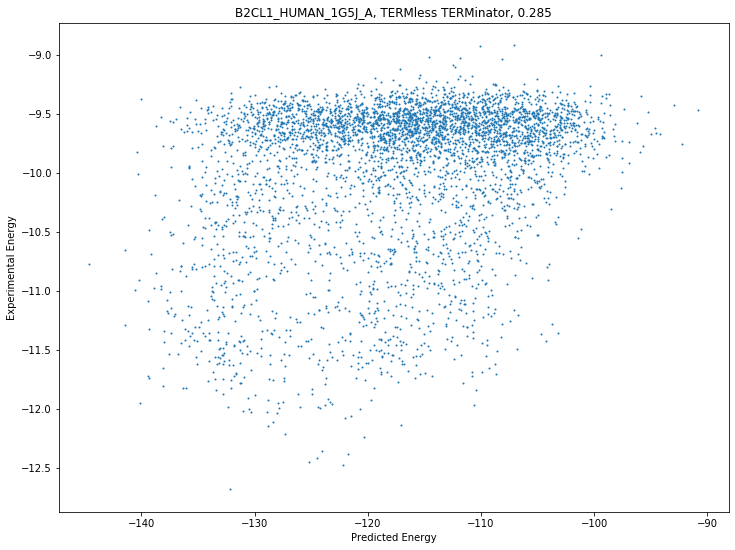

B2CL1_HUMAN_2M04_A_holo_dTERMenC35 0.2264732817493098


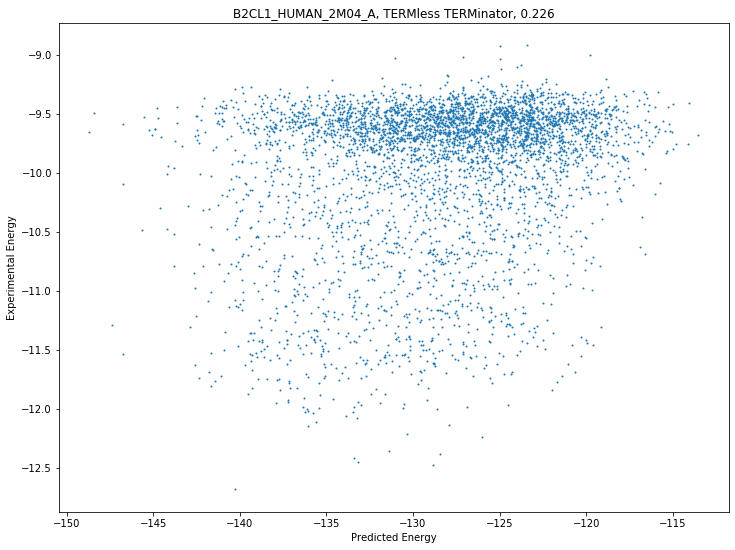

B2CL1_HUMAN_2P1L_A_holo_dTERMenC35 0.1334400047363131


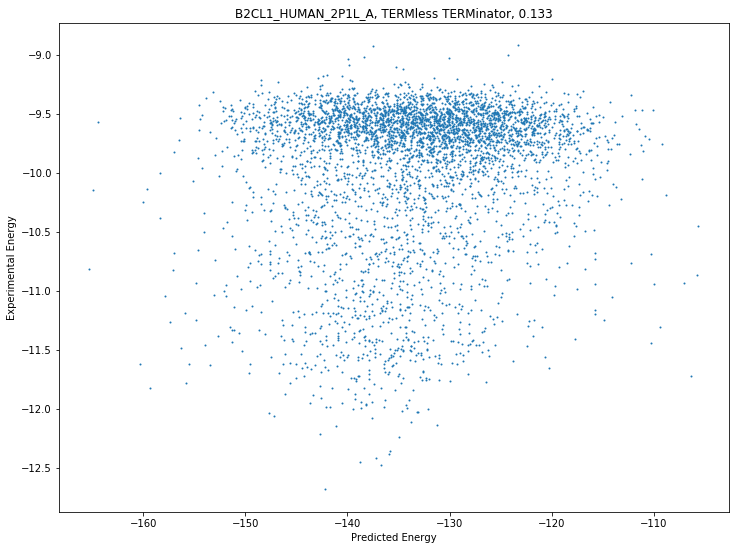

B2CL1_HUMAN_2P1L_C_holo_dTERMenC35 0.09865222758198627
B2CL1_HUMAN_2P1L_E_holo_dTERMenC35 0.05503732824953714
B2CL1_HUMAN_2P1L_G_holo_dTERMenC35 0.09216191813297082
B2CL1_HUMAN_2PON_B_holo_dTERMenC35 0.05978176633286203
B2CL1_HUMAN_3FDL_A_holo_dTERMenC35 0.22605174457414345
B2CL1_HUMAN_3IO8_A_holo_dTERMenC35 0.30515767585679887
B2CL1_HUMAN_3PL7_A_holo_dTERMenC35 0.09952470008962128
B2CL1_HUMAN_4CIN_A_holo_dTERMenC35 -0.03776421343605673
B2CL1_HUMAN_4HNJ_A_holo_dTERMenC35 0.16484390799381862
B2CL1_HUMAN_4QVE_A_holo_dTERMenC35 0.15530664197787294
B2CL1_HUMAN_4QVF_A_holo_dTERMenC35 0.09589022223399295
B2CL1_HUMAN_5FMK_A_holo_dTERMenC35 -0.01876535286766755
B2CL1_HUMAN_MIN_dTERMenC35 0.06601214996597474
MCL1_SORTCERY
MCL1_HUMAN_2KBW_A_holo_dTERMenC35 0.4122477364830102


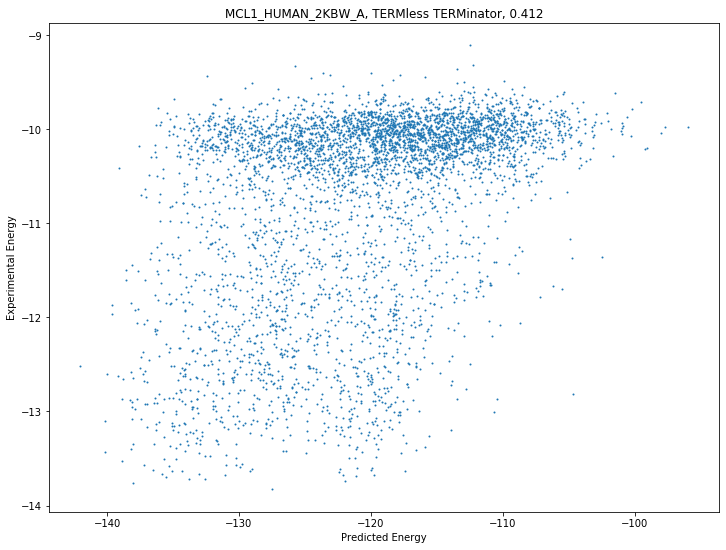

MCL1_HUMAN_2NL9_A_holo_dTERMenC35 0.4767351627123167


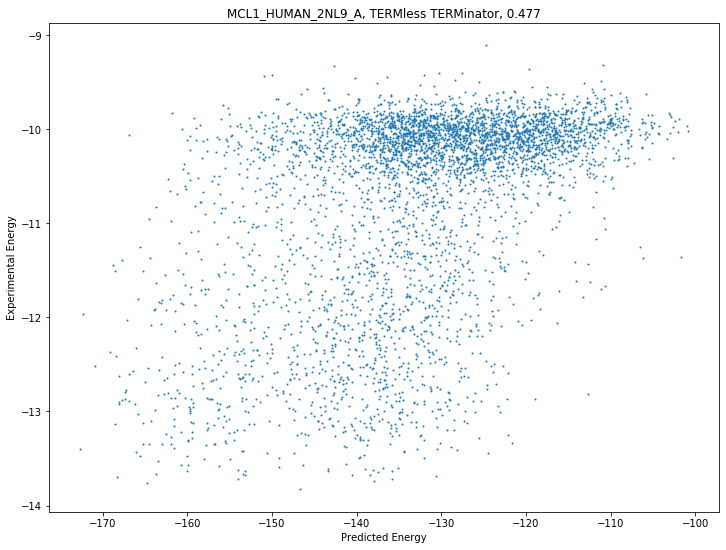

MCL1_HUMAN_2PQK_A_holo_dTERMenC35 0.44903041407312716


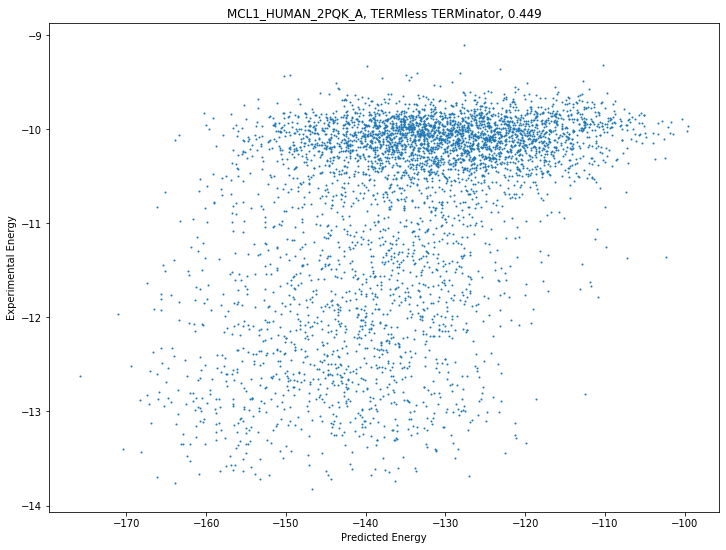

MCL1_HUMAN_3D7V_A_holo_dTERMenC35 0.45400120723064075
MCL1_HUMAN_3IO9_A_holo_dTERMenC35 0.5036764582988078
MCL1_HUMAN_3KJ0_A_holo_dTERMenC35 0.3324099710378104
MCL1_HUMAN_3KJ1_A_holo_dTERMenC35 0.41334668624739657
MCL1_HUMAN_3KJ2_A_holo_dTERMenC35 0.5068684539202543
MCL1_HUMAN_3KZ0_A_holo_dTERMenC35 0.46680334454552974
MCL1_HUMAN_3KZ0_B_holo_dTERMenC35 0.4467992136442246
MCL1_HUMAN_3PK1_A_holo_dTERMenC35 0.3904404194819641
MCL1_HUMAN_3PK1_C_holo_dTERMenC35 0.4410911445733576
MCL1_HUMAN_5C6H_A_holo_dTERMenC35 0.40991765002211344
MCL1_HUMAN_5C6H_C_holo_dTERMenC35 0.29215122209644256
MCL1_HUMAN_5C6H_E_holo_dTERMenC35 0.30595513533148455
MCL1_HUMAN_5C6H_G_holo_dTERMenC35 0.34164058201943354
MCL1_HUMAN_5C6H_I_holo_dTERMenC35 0.29252481597760277
MCL1_HUMAN_5C6H_K_holo_dTERMenC35 0.3705252983873142
MCL1_HUMAN_5C6H_M_holo_dTERMenC35 0.3954113539242466
MCL1_HUMAN_5C6H_O_holo_dTERMenC35 0.2988149091845081
MCL1_HUMAN_5C6H_Q_holo_dTERMenC35 0.3264318380416551
MCL1_HUMAN_5C6H_U_holo_dTERMenC35 0.36

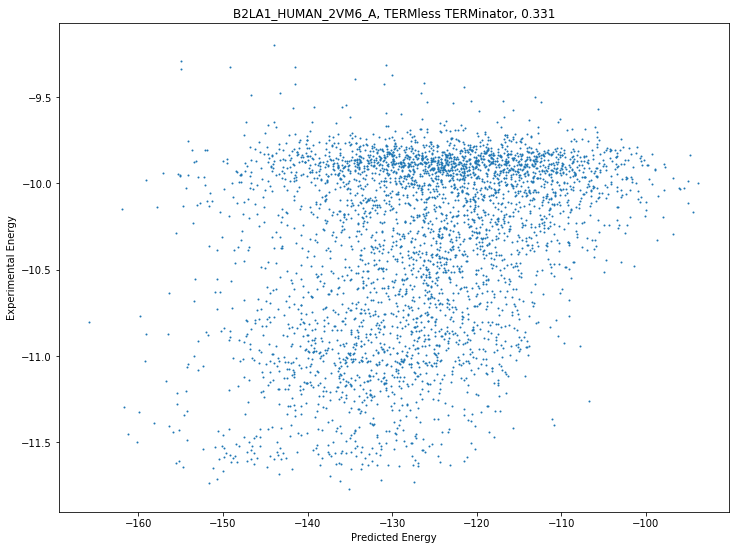

B2LA1_HUMAN_3MQP_A_holo_dTERMenC35 0.2446589604705241


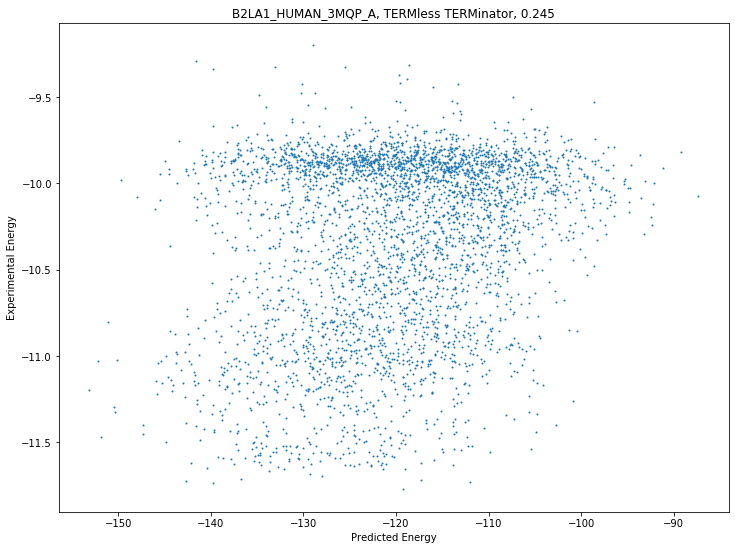

B2LA1_HUMAN_4ZEQ_A_holo_dTERMenC35 0.31861768316134875


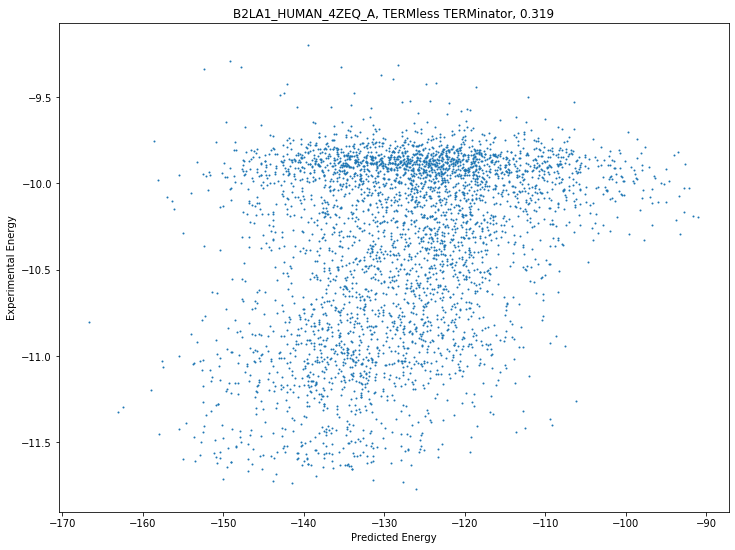

B2LA1_HUMAN_5UUK_A_holo_dTERMenC35 0.19358631867735243
B2LA1_HUMAN_5UUL_A_holo_dTERMenC35 0.24294914003882015
B2LA1_HUMAN_5UUP_A_holo_dTERMenC35 0.3794979529959686
B2LA1_HUMAN_MIN_dTERMenC35 0.302872397730053


In [184]:
#New name
NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

#Get Correlation and AUC

#Dict with metric
ModCor = dict()
ModAUC = dict()
ModEnr = dict()
ModProtAUC = dict()

for bench in NameTest:
    print(bench)
    ExpRec = bench.split("_")[0]
    #Get bench
    OnlyBench = PepBindEnerDF.dropna(subset=[bench])
    
    #Get Binary
    binary_bench = "binary_"+bench
    BinaryOnlyBench = PepBindEnerDF.dropna(subset=[binary_bench])

    count = 0 
    for template in list(PepBindEnerDF.columns):
        if template == bench:continue
        #Need to be same receptor
        TempRec = template.split("_")[0]
        if TempRec != ExpRec:
            continue
            
        #Get PDB and model name
        sp = template.split("_")
        mod = sp[-1]
        pdb = "_".join(sp[:4])
        if "MIN" in template:
            pdb = "_".join(sp[:3])
        
        #Get data
        subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
        Pred = subdf[template].values
        Exp = subdf[bench].values
        
        #Pearson product-moment correlation coefficients
        cor = np.corrcoef(Pred,Exp)[0][1]

        if mod == "dTERMenC35":
            print(template, cor)
            count += 1
            if count <= 3: # TODO change this to change the number of graphs per family
                plt.figure(figsize=(12,9))
                plt.scatter(Pred, Exp, s=1)
                plt.title("{}, TERMless TERMinator, {}".format(pdb,round(cor,3)))
                plt.xlabel("Predicted Energy")
                plt.ylabel("Experimental Energy")
                plt.show()
        
        #Get Enrich
        topbind = rankdata(Exp) < len(Exp) / 10
        enrich = np.sum(topbind[:len(Exp)//10])/(len(Exp)/10.0)*100

        #Get resolved data
        Binarysubdf = BinaryOnlyBench.dropna(subset=[template])
        BinaryPred = Binarysubdf[template].values
        BinaryExp = Binarysubdf[binary_bench].values

        fpr, tpr, thresholds = metrics.roc_curve(BinaryExp > 0.5, -BinaryPred, pos_label=True)
        auc = metrics.auc(fpr, tpr)
        
        #Store info
        if mod not in ModCor:
            ModCor[mod] = dict()
            ModAUC[mod] = dict()
            ModEnr[mod] = dict()
            ModProtAUC[mod] = dict()
        
        ModCor[mod][pdb] = cor
        ModAUC[mod][pdb] = auc
        ModEnr[mod][pdb] = enrich
        
        #Protoeme bench
        protbench = "binary_"+bench.split("_")[0]+"_Proteome"
        protbenchDF = PepBindEnerDF.dropna(subset=[protbench])
        subdfProt = protbenchDF.dropna(subset=[template]).sort_values(by=template)
        if len(subdfProt) > 10:
            fpr, tpr, thresholds = metrics.roc_curve(subdfProt[protbench] > 0.5, -subdfProt[template], pos_label=True)
            aucprot = metrics.auc(fpr, tpr)
            ModProtAUC[mod][pdb] = aucprot

In [185]:
ModProtAUCDF = pd.DataFrame(ModProtAUC)
for recep in ["B2CL1","MCL1","B2LA1"]:
    subdf = ModProtAUCDF.filter(regex=recep+"_HUMAN_...._.",axis=0)
    trans = ModProtAUCDF.transpose()
    trans[recep+"_HUMAN_MEAN"] = subdf.mean()
    ModProtAUCDF = trans.transpose()

In [186]:
subdf = ModProtAUCDF.filter(regex="_M..",axis=0)[["FoldX","RosettabetaInterfacedGseparated","dTERMenC35"]]

In [187]:
min_mean = subdf.filter(regex="_MIN",axis=0).mean()
mean_mean = subdf.filter(regex="_MEAN",axis=0).mean()

subdf = subdf.transpose()
subdf["ALL_MIN"] = min_mean
subdf["ALL_MEAN"] = mean_mean
subdf = subdf.transpose()

In [188]:
for bench in NameTest:
    binary_bench = "binary_"+bench
    BinaryOnlyBench = PepBindEnerDF.dropna(subset=[binary_bench])[[binary_bench,bench]]
    print((len(BinaryOnlyBench),len(BinaryOnlyBench.dropna(axis=0))))    

(1872, 1770)
(1855, 1698)
(1686, 1543)


In [189]:
for bench in NameTest:
    binary_bench = "binary_"+bench
    BinaryOnlyBench = PepBindEnerDF.dropna(subset=[binary_bench,bench],how="all")
    print((bench,len(BinaryOnlyBench)))

('B2CL1_SORTCERY', 4488)
('MCL1_SORTCERY', 4648)
('B2LA1_SORTCERY', 3948)


In [190]:
pickle.dump(pd.DataFrame(ModCor),open(f"../computed_data/AffCor_{FILE_SUFFIX}.pickle","wb"))
pickle.dump(pd.DataFrame(ModAUC),open(f"../computed_data/AUCval_{FILE_SUFFIX}.pickle","wb"))
pickle.dump(pd.DataFrame(ModEnr),open(f"../computed_data/EnrVal_{FILE_SUFFIX}.pickle","wb"))
pd.DataFrame(ModCor).to_csv(f"../computed_data/AffCor_{FILE_SUFFIX}.csv")
pd.DataFrame(ModAUC).to_csv(f"../computed_data/AUCval_{FILE_SUFFIX}.csv")
pd.DataFrame(ModEnr).to_csv(f"../computed_data/EnrVal_{FILE_SUFFIX}.csv")

In [191]:
#Merge everything
AllConcat = dict()
for (prefix,d) in zip(["AUC","Cor","Enrich"],[ModAUC,ModCor,ModEnr]):
    for m in sorted(d.keys()):
        nm = "_".join([prefix,m])
        AllConcat[nm] = dict()
        for t in d[m].keys():
            AllConcat[nm][t] = d[m][t]
PDBinfo = dict()

In [192]:
#Get PUBMED ID

for k in sorted(AllConcat["AUC_FoldX"].keys()):
    #Get PDB id
    pdbid = k
    
    #Init dict
    if pdbid not in PDBinfo:
        PDBinfo[pdbid] = dict()
    PDBinfo[pdbid]["Receptor_chain"] = k.split("_")[-1]
    PDBinfo[pdbid]["PDBID"] = k.split("_")[-2]
    PDBinfo[pdbid]["Receptor"] = k.split("_")[0]
    #
    if "DOI" in PDBinfo[pdbid]:
        continue
    #Get url and source
    if len(k.split("_")[-2]) != 4:
        print(k,len(k.split("_")[-2]),"I CONTINUE")
        continue
    url = "https://files.rcsb.org/header/"+k.split("_")[-2]+".pdb"
    r = requests.get(url)
    print(url)
    #Parse the output
    authors = ""
    title = ""
    pubmedid = ""
    doi = ""
    resolution = -999
    for l in r.text.split("\n"):
        if "JRNL" in l[:4]:
            ls = l[19:]
            ls = re.sub("\s+$","",ls)
            if "AUTH" in l[:19]:
                authors += ls
            if "TITL" in l[:19]:
                title += ls
            if "PMID" in l[:19]:
                pubmedid += ls
            if "DOI" in l[:19]:
                doi += ls
        if "REMARK   2 RESOLUTION. " in l:
            m = re.search("REMARK   2 RESOLUTION.\s+(\d+\.\d+) ANGSTROM",l)
            if m != None:
                resolution = float(m.group(1))
    
    #Store info
    PDBinfo[pdbid]["DOI"] = doi
    PDBinfo[pdbid]["PMID"] = pubmedid
    PDBinfo[pdbid]["Title"] = title
    PDBinfo[pdbid]["Authors"] = authors
    PDBinfo[pdbid]["Resolution"] = resolution

https://files.rcsb.org/header/1G5J.pdb
https://files.rcsb.org/header/2M04.pdb
https://files.rcsb.org/header/2P1L.pdb
https://files.rcsb.org/header/2P1L.pdb
https://files.rcsb.org/header/2P1L.pdb
https://files.rcsb.org/header/2P1L.pdb
https://files.rcsb.org/header/2PON.pdb
https://files.rcsb.org/header/3FDL.pdb
https://files.rcsb.org/header/3IO8.pdb
https://files.rcsb.org/header/3PL7.pdb
https://files.rcsb.org/header/4CIN.pdb
https://files.rcsb.org/header/4HNJ.pdb
https://files.rcsb.org/header/4QVE.pdb
https://files.rcsb.org/header/4QVF.pdb
https://files.rcsb.org/header/5FMK.pdb
B2CL1_HUMAN_MIN 5 I CONTINUE
https://files.rcsb.org/header/2VM6.pdb
https://files.rcsb.org/header/3MQP.pdb
https://files.rcsb.org/header/4ZEQ.pdb
https://files.rcsb.org/header/5UUK.pdb
https://files.rcsb.org/header/5UUL.pdb
https://files.rcsb.org/header/5UUP.pdb
B2LA1_HUMAN_MIN 5 I CONTINUE
https://files.rcsb.org/header/2KBW.pdb
https://files.rcsb.org/header/2NL9.pdb
https://files.rcsb.org/header/2PQK.pdb
https:

In [193]:
#Add to concat
for cat in ["Receptor","PDBID","Receptor_chain","Resolution","DOI","PMID","Title","Authors"]:
    AllConcat[cat] = dict()
    for k in PDBinfo:
        if cat not in PDBinfo[k]:continue
        AllConcat[cat][k] = PDBinfo[k][cat]

In [194]:
AllConcatDF = pd.DataFrame(AllConcat)
AllConcatDFCol = ["Receptor","PDBID","Receptor_chain","Resolution","DOI","PMID","Title","Authors"]
for reg in ["AUC_","Cor_","Enrich_"]:
    AllConcatDFCol +=  list(AllConcatDF.filter(regex=reg).columns)
#Check if all present
for c in AllConcatDF.columns:
    if c not in AllConcatDFCol:
        print(c)
AllConcatDF = AllConcatDF[AllConcatDFCol]

In [195]:
AllConcatDF = AllConcatDF.sort_values(by=["Receptor","PDBID","Receptor_chain"])

In [196]:
AllConcatDF.to_csv(f"../computed_data/ConcatBench_{FILE_SUFFIX}.csv")
# AllConcatDF.to_csv(f"../Figures/Supp_table_1_ConcatBench_{FILE_SUFFIX}.csv")
AllConcatDF.to_pickle(f"../computed_data/ConcatBench_{FILE_SUFFIX}.pk")

In [197]:
def PDBtoSeq(PDB):
    UniqueRes = {}
    UniqueCha = {}
    for Res in PDB:
        if not Res['resnumc'] in UniqueRes:
            UniqueRes[Res['resnumc']] = 0
        UniqueRes[Res['resnumc']] += 1
        if not Res['cha'] in UniqueCha:
            UniqueCha[Res['cha']] = {}
        if not Res['num'] in UniqueCha[Res['cha']]:
            UniqueCha[Res['cha']][Res['num']] = 0
        UniqueCha[Res['cha']][Res['num']] = Res['resnumc']
    ResNumC = []
    SeqToScore = ""
    RealPep = ""
    for chain in sorted(UniqueCha):
        SeqToScore = SeqToScore + RealPep
        RealPep = ""
        for res in sorted(UniqueCha[chain],key=float):
            ResNumC.append(UniqueCha[chain][res])
            mySp = UniqueCha[chain][res].split(" ")
            for treeAAInd in range(0,len(FullAmino)):
                if FullAmino[treeAAInd] == mySp[0]:
                    RealPep = RealPep  + myAmino[treeAAInd]

    return(SeqToScore,RealPep,ResNumC)
def read_pdb_seq(myF,keep_hydrogen = 1,keep_het = 1,mask=""):
    lines = [line.rstrip('\n') for line in open(myF)]
    Nresnumc = "NA"
    myPDB = []
    myC = 0
    for l in lines:
        # My hash
        raw = {}
        if (re.search(' H\s*$',l) != None and keep_hydrogen == 0):
            continue
        if (re.search('^HET',l) != None and keep_het == 0):
            continue
        if mask != "":
            pattern = re.compile(mask)
            if not pattern.search(l):
                continue
        m = re.search('^ATOM........(....).(...) (.)\s*(\d+)\s*(-*\d+\.\d{3})\s*(-*\d+.\d{3})\s*(-*\d+.\d{3})', l)
        if (m == None):
            print('Can t find patern in '+l)
            continue
        # Get resnumc
        resnumc = str(m.group(2)) + " " + str(m.group(4)) + " " + str(m.group(3))
        myCord = m.group(5,6,7)
        nCord = [float(i) for i in myCord]
        raw['coord'] = nCord
        raw['res'] = m.group(2)
        raw['num'] = m.group(4)
        raw['cha'] = m.group(3)
        raw['atom'] = m.group(1)
        raw['resnumc'] = resnumc
        raw['ID'] = myC
        myC += 1
        myPDB.append(raw)
    return(myPDB)
def get_peptide(PDB,chain="B"):
    tempPep = []
    for res in PDB:
        if res["cha"] == chain:
            tempPep.append(res)
    return(tempPep)

In [198]:
#Make alignment of recep
#Need clustalw2 installed
AllFile = glob.glob("../pdb/clean_pdb/*holo*")
print("PDB files = %d" % len(AllFile))

SeqFile = "../wrk/BenchRecep.fa"
ToWrite = open(SeqFile,"w")
for f in AllFile:
    #Only only form
    if "_holo" not in f:
        continue
    #Only Human
    if "HUMAN" not in f:
        continue
        
    #Get name
    name = re.split("\\\\",f)[-1][:-4]
    pdbname = re.split("_",name)[2]
    
    
    PDB = read_pdb_seq(f,keep_hydrogen = 0,keep_het = 0,mask="ATOM.* CA .*")
    seq = PDBtoSeq(PDB)[0]
    ToWrite.write(">%s\n%s\n" % (name,seq))
    #print(name,seq)
ToWrite.close()

subprocess.run(["clustalw2", SeqFile],shell=True)

PDB files = 63


CompletedProcess(args=['clustalw2', '../wrk/BenchRecep.fa'], returncode=0)

In [199]:
#Load ali
f = "../wrk/BenchRecep.aln"
lines = [line.rstrip('\n') for line in open(f)]
AllAli = dict()

for l in lines[3:-1]:
    sp = re.split("\s+",l)
    if len(sp) != 2:continue
    if sp[0] not in AllAli:
        AllAli[sp[0]] = []
    AllAli[sp[0]] += list(sp[1])

In [200]:
def find_bindingsite(FullRecepRes,FullPeptideRes,Thres = 8.0):
    SqrThresh = Thres*Thres
    BindingSite = []
    for RecAtm in FullRecepRes:
        if RecAtm["resnumc"] in BindingSite:
            continue
        RecCor = np.array(RecAtm["coord"]) 
        for pepaa in FullPeptideRes:
            PepCor = np.array(pepaa["coord"]) 
            dist = np.sum(np.power(RecCor - PepCor,2))
            if dist < SqrThresh:
                BindingSite.append(RecAtm["resnumc"])
                break
    return(BindingSite)

In [201]:
#Get peptide cordinate
AllPep = []
AllName = []
AllBS = []
AllSeq = []
AllPDB = []
#Get 

PDB_done = []

for f in AllFile:
    #Only only form
    if "_holo" not in f:
        continue
    #Only Human
    if "HUMAN" not in f:
        continue
    
    #Get name
    name = re.split("\\\\",f)[-1][:-4]
    pdbname = re.split("_",name)[2]
    
    #Get PDB
    PDB = read_pdb_seq(f,keep_hydrogen = 0,keep_het = 0,mask="ATOM.* CA .*")
    #Get PeptideRes
    PeptideRes = get_peptide(PDB)
    #Some fileter
    seq = PDBtoSeq(PeptideRes)[1]
    if len(seq) != 20:
         continue
    
    #Find Binding Site
    FullPDB = read_pdb_seq(f,keep_hydrogen = 0,keep_het = 0,mask="ATOM.* ")
    FullPeptideRes = get_peptide(FullPDB)
    FullRecepRes = get_peptide(FullPDB,chain="A")
    BindingSite = find_bindingsite(FullRecepRes,FullPeptideRes,Thres = 8.0)
    
    #Map PDB to Ali
    c = -1
    for i in range(0,len(AllAli[name])):
        if AllAli[name][i] != "-":
            c += 1
            PDB[c]["aln_id"] = i
    
    #Kept CA atom
    BSRes = []
    for bs in BindingSite:
        for res in PDB:
            if res["resnumc"] == bs:
                BSRes.append(res)
                break

    AllName.append(name)
    AllPep.append(PeptideRes)
    AllSeq.append(seq)
    AllBS.append(BSRes)
    AllPDB.append(PDB)

In [202]:
def AlignStrc(pep1,pep2):
    iPDB = vcopy.deepcopy(pep1)
    tPDB = vcopy.deepcopy(pep2)

    #Center both pdb to origin
    isumCor = np.array([0.0,0.0,0.0])
    for res in iPDB:
        isumCor += np.array(res["coord"])
    isumCor = isumCor/float(len(iPDB))
    niPDB = []
    for res in iPDB:
        niPDB.append(np.array(res["coord"])-isumCor)
    #Center both pdb to origin
    tsumCor = np.array([0.0,0.0,0.0])
    for res in tPDB:
        tsumCor += np.array(res["coord"])
    tsumCor = tsumCor/float(len(tPDB))
    ntPDB = []
    for res in tPDB:
        ntPDB.append(np.array(res["coord"])-tsumCor)

    irmsd = 0.0
    for k in range(len(ntPDB)):
        irmsd += np.sum(np.power(ntPDB[k]-niPDB[k],2))
    irmsd = math.sqrt(irmsd/ float(len(ntPDB)))
    corr = np.dot(np.matrix(niPDB).transpose(),np.matrix(ntPDB))
    u, d, vt = np.linalg.svd(corr)
    rota = np.transpose(np.dot(np.transpose(vt), np.transpose(u))) 
    
    if np.linalg.det(rota) < 0: 
        vt[2] = -vt[2] 
        rota = np.transpose(np.dot(np.transpose(vt), np.transpose(u))) 
    
    
    ripdb = []
    for ces in niPDB:
        nres = np.dot(ces,rota).tolist()[0]
        ripdb.append(nres)
    rmsd = 0.0
    alldev = []
    for k in range(len(ntPDB)):
        #print(k,np.sum(np.power(ntPDB[k]-ripdb[k],2)),np.sum(np.power(ntPDB[k]-niPDB[k],2)))
        alldev.append((np.sum(np.power(ntPDB[k]-ripdb[k],2))))
        rmsd += np.sum(np.power(ntPDB[k]-ripdb[k],2))
    rmsd /= float(len(ntPDB))
    rmsd = math.sqrt(rmsd)

    return(rmsd,alldev)

In [203]:
#Get RMSD between peptide
AllRMSD = dict()
PepRMSD = dict()
RecRMSD = dict()

for i in range(0,len(AllName)):
    #Get Name and pep
    name1 = AllName[i]
    pep1 = AllPep[i]
    BS1 = AllBS[i]
    for j in range(i+1,len(AllName)):
        #Get Name and pep
        name2 = AllName[j]
        pep2 = AllPep[j]
        BS2 = AllBS[j]
        
        #Align on top
        Strc1 = vcopy.deepcopy(pep1)
        Strc2 = vcopy.deepcopy(pep2)
        
        RecRmsd = []        
        for bs1 in BS1:
            for bs2 in BS2:
                if bs1["aln_id"] != bs2["aln_id"]:continue
                Strc1.append(bs1)
                Strc2.append(bs2)  
        (rmsd,alldev) = AlignStrc(Strc1,Strc2)
        if name1 not in AllRMSD:AllRMSD[name1] = dict()
        if name2 not in AllRMSD:AllRMSD[name2] = dict()
            
        AllRMSD[name1][name2] = rmsd
        AllRMSD[name2][name1] = AllRMSD[name1][name2]
        
        AllRMSD[name1][name1] = 0.0
        AllRMSD[name2][name2] = 0.0
        
        
        if name1 not in PepRMSD:PepRMSD[name1] = dict()
        if name2 not in PepRMSD:PepRMSD[name2] = dict()
            
        PepRMSD[name1][name2] = math.sqrt(np.mean(alldev[:len(pep1)]))
        PepRMSD[name2][name1] = PepRMSD[name1][name2]
        
        PepRMSD[name1][name1] = 0.0
        PepRMSD[name2][name2] = 0.0
        
        if name1 not in RecRMSD:RecRMSD[name1] = dict()
        if name2 not in RecRMSD:RecRMSD[name2] = dict()
            
        RecRMSD[name1][name2] = math.sqrt(np.mean(alldev[len(pep1):]))
        RecRMSD[name2][name1] = RecRMSD[name1][name2]
        
        RecRMSD[name1][name1] = 0.0
        RecRMSD[name2][name2] = 0.0

In [204]:
pd.DataFrame(AllRMSD).to_csv(f"../computed_data/pep_rmsd_{FILE_SUFFIX}.csv")

In [205]:
#Get robustness
#Load ener
PepBindEnerDF = pickle.load( open(f"../computed_data/PepBindEnerDF_{FILE_SUFFIX}.pickle","rb"))

In [206]:
AllTemp = list(PepBindEnerDF.columns)

RobusVal = dict()
RobusVal["rmsd"] = dict()
for i in range(len(AllTemp)):
    #Get name
    t1 = AllTemp[i]
    
    #Ignore apo
    if "apo" in t1:continue
    
    #Next min, because no cryst
    if "_MIN_" in t1:continue
    if "SORTCERY" in t1:continue
    
    #Get Mod and PDB
    sp = t1.split("_")
    mod1 = sp[-1]
    pdb1 = "_".join(sp[:5])

    # TODO change hacky fix
    if pdb1[-9:] == "condensed":
        pdb1 = pdb1[:-9]
    rec1 = "_".join(sp[:2])
    
    for j in range(i+1,len(AllTemp)):
        t2 = AllTemp[j]
        #Ignore apo
        if "apo" in t2:continue
        #Next min, because no cryst
        if "_MIN_" in t2:continue
        if "SORTCERY" in t2:continue
        
        #Get Mod and PDB
        sp = t2.split("_")
        mod2 = sp[-1]
        pdb2 = "_".join(sp[:5])
        if pdb2[-9:] == "condensed":
            pdb2 = pdb2[:-9]
        rec2 = "_".join(sp[:2])
        
        if mod1 != mod2:
            continue
        if rec1 != rec2:
            continue
        if pdb1 not in AllRMSD:
            print(pdb1,"Not in AllRMSD")
            continue
        if pdb2 not in AllRMSD[pdb1]:
            print(pdb2,"Not in AllRMSD",pdb1)
            continue
        rmsd = AllRMSD[pdb1][pdb2]
        subdf = PepBindEnerDF[[t1,t2]].dropna()
        cor = np.corrcoef(subdf[t1],subdf[t2])[0][1]
        if mod1 not in RobusVal:
            RobusVal[mod1] = dict()
        pdbCon = "_".join([pdb1,pdb2])
        RobusVal["rmsd"][pdbCon] = rmsd
        RobusVal[mod1][pdbCon] = cor
        if (rmsd < 0.5) & (cor < 0.2):
            plt.scatter(subdf[t1],subdf[t2],s=0.2)
            plt.title("%s RMSD=%.2f Cor=%.2f" % (mod1,rmsd,cor))
            plt.xlabel(t1)
            plt.ylabel(t2)
            plt.show()
RobusValDF = pd.DataFrame(RobusVal)

In [207]:
RobusValDF = RobusValDF.sort_values(by="rmsd")
RobusValDF.to_csv(f"../computed_data/RobusVal_{FILE_SUFFIX}.csv")
pickle.dump(RobusValDF,open(f"../computed_data/RobusVal_{FILE_SUFFIX}.pickle","wb"))
pd.DataFrame(AllRMSD).to_csv(f"../computed_data/BindingModeRMSD_{FILE_SUFFIX}.csv")

In [208]:
ModCorDF = pickle.load(open(f"../computed_data/AffCor_{FILE_SUFFIX}.pickle","rb"))
ModCorDF.sort_index(inplace=True)

ModAUCDF = pickle.load(open(f"../computed_data/AUCval_{FILE_SUFFIX}.pickle","rb"))
ModAUCDF.sort_index(inplace=True)

ModEnrDF = pickle.load(open(f"../computed_data/EnrVal_{FILE_SUFFIX}.pickle","rb"))
ModEnrDF.sort_index(inplace=True)

RobusValDF = pickle.load(open(f"../computed_data/RobusVal_{FILE_SUFFIX}.pickle","rb"))
RobusValDF.sort_index(inplace=True)

AllConcatDF = pickle.load(open(f"../computed_data/ConcatBench_{FILE_SUFFIX}.pk","rb"))
AllConcatDF.sort_index(inplace=True)


In [209]:
#Default color
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

In [210]:
#Relation between AUC and COR
ModToRun = ["FoldX","RosettabetaInterfacedGseparated","dTERMenC35"]
ModToRunName = ["FoldX","Rosetta","dTERMen"]
Receps = ["B2CL1","MCL1","B2LA1"]

FoldX 0.25 0.7811421253528018
FoldX 0.75 0.46670405731625025
FoldX 1.5 0.461633488742337
FoldX 4.0 0.31430480602076055
RosettabetaInterfacedGseparated 0.25 0.6211066464651793
RosettabetaInterfacedGseparated 0.75 0.5925795349420644
RosettabetaInterfacedGseparated 1.5 0.3492984264679291
RosettabetaInterfacedGseparated 4.0 0.1951120092814154
dTERMenC35 0.25 0.9370303865397435
dTERMenC35 0.75 0.7486521657736893
dTERMenC35 1.5 0.6706411512956373
dTERMenC35 4.0 0.3892491937120811


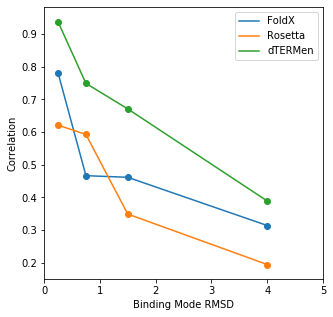

In [211]:
plt.figure(figsize=(5,5))

Bin = [0,0.5,1.0,2.0,6.0]

BelowOne = []
Thresh = 1.0
for (t,name,c) in zip(ModToRun,ModToRunName,new_colors):
    x = []
    y = []
    ind = RobusValDF["rmsd"].values < Thresh
    BelowOne.append(RobusValDF[t].values[ind])
    for i in range(1,len(Bin)):
        ind = (RobusValDF["rmsd"].values < Bin[i]) & (RobusValDF["rmsd"].values >= Bin[i-1])
        sub = RobusValDF[t].values[ind]
        xi = (Bin[i]+Bin[i-1])/2.0
        yi = np.nanmean(sub)
        ystd = np.nanstd(sub)
        plt.scatter(xi,yi,c=c)
        print(t,xi,yi)
        #plt.plot([xi,xi],[yi+ystd,yi-ystd],c=c)
        #plt.plot([xi-0.05,xi+0.05],[yi+ystd,yi+ystd],c=c)
        #plt.plot([xi-0.05,xi+0.05],[yi-ystd,yi-ystd],c=c)
        #plt.scatter((,np.mean(sub),c=c)
        
        x.append(xi)
        y.append(yi)
    plt.plot(x,y,c=c,label=name)
plt.xlabel("Binding Mode RMSD")    
plt.ylabel("Correlation")
plt.legend(loc=0)
plt.xlim([0,5])
plt.show()

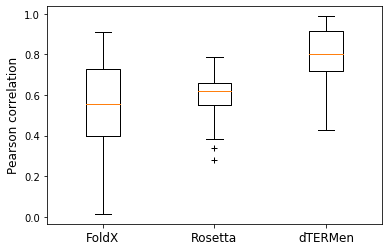

[0.54873138 0.60002139 0.79779431]
299


In [212]:
#Make figure for Plos Comp
BelowOneNoNaNMask = ~np.isnan(BelowOne)
BelowOneNoNaN = [d[m] for d, m in zip(BelowOne, BelowOneNoNaNMask)]

plt.boxplot(BelowOneNoNaN,sym='+')
plt.xticks(range(1,len(ModToRunName)+1),ModToRunName,size=12)
plt.ylabel("Pearson correlation",size=12)
plt.savefig(f"../Figures/Figure1_{FILE_SUFFIX}.tiff",dpi=300,format="TIFF")
plt.show()
print(np.mean(BelowOneNoNaN,axis=1))
print(len(BelowOneNoNaN[0]))

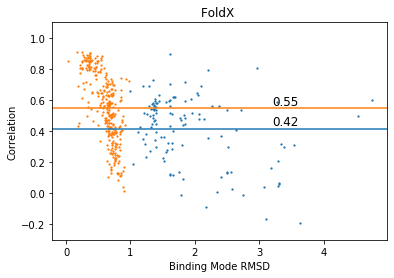

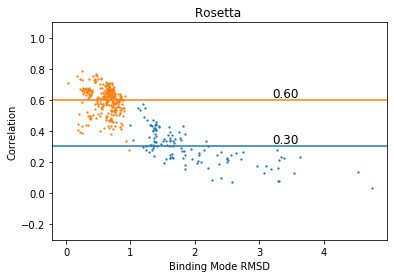

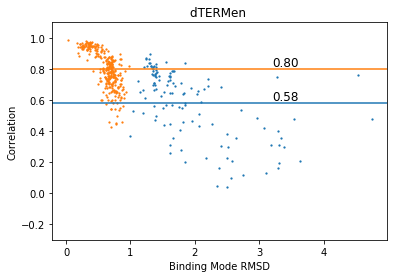

In [213]:
Thres = 1

for (t,name) in zip(ModToRun,ModToRunName):
    lowind = RobusValDF["rmsd"].values < Thres
    higind = RobusValDF["rmsd"].values >= Thres
    
    #Plot high
    plt.scatter(RobusValDF["rmsd"].values[higind],RobusValDF[t].values[higind],c=new_colors[0],s=1.5)
    #Plot low
    plt.scatter(RobusValDF["rmsd"].values[lowind],RobusValDF[t].values[lowind],c=new_colors[1],s=1.5)
    
    #Plot some line
    plt.axhline(np.nanmean(RobusValDF[t].values[higind]),c=new_colors[0])
    plt.axhline(np.nanmean(RobusValDF[t].values[lowind]),c=new_colors[1])
    
    #Plot text
    plt.text(3.2,np.nanmean(RobusValDF[t].values[higind])+0.02,"%.2f" % (np.nanmean(RobusValDF[t].values[higind])),size='large')
    plt.text(3.2,np.nanmean(RobusValDF[t].values[lowind])+0.02,"%.2f" % (np.nanmean(RobusValDF[t].values[lowind])),size='large')
    
    plt.ylim([-0.3,1.1])
    plt.title("%s " % (name))
    plt.xlabel("Binding Mode RMSD")
    plt.ylabel("Correlation")
    plt.show()


In [214]:
#Get average performance
SummarPer = dict()
figsize(10,10)
for recep in Receps:
    AUCsubdf = ModAUCDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
    CORsubdf = ModCorDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
    ENRsubdf = ModEnrDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
    
    # sns.heatmap(ENRsubdf[ModToRun],cmap="Blues",vmax=100.0,annot=True)
    # plt.title("Enrichment")
    # plt.show()
    
    # sns.heatmap(CORsubdf[ModToRun],cmap="bwr",vmax=1.0,vmin=-1.0,annot=True,center=0)
    # plt.title("Cor")
    # plt.show()
    
    # sns.heatmap(AUCsubdf[ModToRun],cmap="bwr",vmax=1.0,vmin=0,annot=True,center=0.5)
    # plt.title("AUC")
    # plt.show()
    
    for (mod,name) in zip(ModToRun,ModToRunName):
        scor = np.corrcoef(AUCsubdf[mod],CORsubdf[mod])[0][1]
        if name+"_mean" not in SummarPer:
            SummarPer[name+"_mean"] = dict()
        SummarPer[name+"_mean"][recep+"_cor"] = np.mean(CORsubdf[mod])
        SummarPer[name+"_mean"][recep+"_AUC"] = np.mean(AUCsubdf[mod])
        SummarPer[name+"_mean"][recep+"_Enrich"] = np.mean(ENRsubdf[mod])
        
        SummarPer[name+"_mean"][recep+"_cor_sd"] = np.std(CORsubdf[mod])
        SummarPer[name+"_mean"][recep+"_AUC_sd"] = np.std(AUCsubdf[mod])
        SummarPer[name+"_mean"][recep+"_Enrich_sd"] = np.std(ENRsubdf[mod])
        
    AUCsubdf = ModAUCDF.filter(regex=recep+".*"+"MIN",axis=0)
    CORsubdf = ModCorDF.filter(regex=recep+".*"+"MIN",axis=0)
    ENRsubdf = ModEnrDF.filter(regex=recep+".*"+"MIN",axis=0)
    for (mod,name) in zip(ModToRun,ModToRunName):
        if name+"_min" not in SummarPer:
            SummarPer[name+"_min"] = dict()
        SummarPer[name+"_min"][recep+"_cor"] = np.mean(CORsubdf[mod])
        SummarPer[name+"_min"][recep+"_AUC"] = np.mean(AUCsubdf[mod])
        SummarPer[name+"_min"][recep+"_Enrich"] = np.mean(ENRsubdf[mod])


In [215]:
SummaryPerDF = pd.DataFrame(SummarPer).transpose()
SummaryPerDF["mean_AUC"] = SummaryPerDF.filter(regex="_AUC$").mean(axis=1)
SummaryPerDF["mean_cor"] = SummaryPerDF.filter(regex="_cor$").mean(axis=1)
SummaryPerDF["mean_Enrich"] = SummaryPerDF.filter(regex="_Enrich$").mean(axis=1)

SummaryPerDF["sd_AUC"] = SummaryPerDF.filter(regex="_AUC$").std(axis=1)
SummaryPerDF["sd_cor"] = SummaryPerDF.filter(regex="_cor$").std(axis=1)
SummaryPerDF["sd_Enrich"] = SummaryPerDF.filter(regex="_Enrich$").std(axis=1)

In [216]:
SummaryPerDF.to_csv(f"../computed_data/Summary_{FILE_SUFFIX}.csv")

B2CL1 FoldX 0.22549564361774888 0.6837182624655856
B2CL1 RosettabetaInterfacedGseparated 0.23794665221952707 0.6881785163430983
B2CL1 dTERMenC35 0.12936447860894235 0.5692380100111251
B2CL1 FoldX_MIN 0.38996079556195123 0.801427247366715
B2CL1 RosettabetaInterfacedGseparated_MIN 0.2502911579561749 0.7042399656657065
B2CL1 dTERMenC35_MIN 0.06601214996597474 0.5175027280239974
MCL1 FoldX 0.3711635674198435 0.8222256006006439
MCL1 RosettabetaInterfacedGseparated 0.4541255897906524 0.8472009229143866
MCL1 dTERMenC35 0.37401141349176514 0.7773516134658991
MCL1 FoldX_MIN 0.5608239598928684 0.9313250770393627
MCL1 RosettabetaInterfacedGseparated_MIN 0.5396404231590085 0.9192813535670679
MCL1 dTERMenC35_MIN 0.3439511834974304 0.7537391708820281
B2LA1 FoldX 0.3382651787182018 0.7491981507983079
B2LA1 RosettabetaInterfacedGseparated 0.315689784422947 0.7210898371761708
B2LA1 dTERMenC35 0.28502837743428505 0.6970227214841644
B2LA1 FoldX_MIN 0.46329287468929126 0.8342071824487194
B2LA1 Rosettabeta

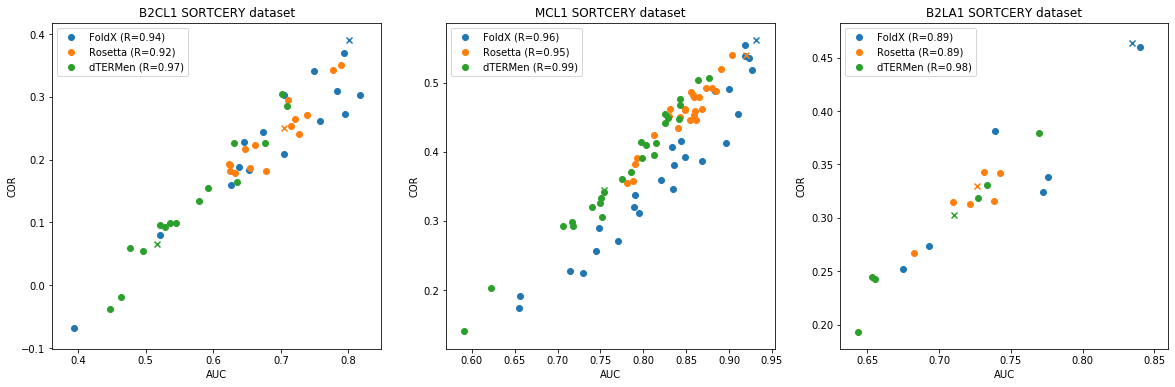

In [217]:
figsize(20,6)
plt.figure(1)
for recep in Receps:
    AUCsubdf = ModAUCDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
    CORsubdf = ModCorDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
    plt.subplot(1,3,Receps.index(recep)+1)
    for (mod,name,i) in zip(ModToRun,ModToRunName,range(len(ModToRun))):
        scor = np.corrcoef(AUCsubdf[mod],CORsubdf[mod])[0][1]
        plt.scatter(AUCsubdf[mod],CORsubdf[mod],label=name + " (R=%.2f)" % scor,c=new_colors[i])
        #plt.axhline(np.mean(CORsubdf[mod]))
        #plt.axvline(np.mean(AUCsubdf[mod]))
        print(recep,mod,np.mean(CORsubdf[mod]),np.mean(AUCsubdf[mod]))
    plt.legend(loc=2)
    AUCsubdf = ModAUCDF.filter(regex=recep+".*"+"MIN",axis=0)
    CORsubdf = ModCorDF.filter(regex=recep+".*"+"MIN",axis=0)
    for (mod,name,i) in zip(ModToRun,ModToRunName,range(len(ModToRun))):
        plt.scatter(AUCsubdf[mod],CORsubdf[mod],marker="x",c=new_colors[i])
        print(recep,mod+"_MIN",np.mean(CORsubdf[mod]),np.mean(AUCsubdf[mod]))
        
    plt.title(recep+" SORTCERY dataset")
   
    plt.xlabel("AUC")
    plt.ylabel("COR")
plt.show()

B2CL1 FoldX 20.32223742210062 0.6837182624655856
B2CL1 RosettabetaInterfacedGseparated 20.448095194323376 0.6881785163430983
B2CL1 dTERMenC35 15.762273901808786 0.5692380100111251
B2CL1 FoldX_MIN 27.359781121751027 0.801427247366715
B2CL1 RosettabetaInterfacedGseparated_MIN 20.063839489284085 0.7042399656657065
B2CL1 dTERMenC35_MIN 12.083903328773369 0.5175027280239974
MCL1 FoldX 23.896682253395678 0.8222256006006439
MCL1 RosettabetaInterfacedGseparated 33.99321305721314 0.8472009229143866
MCL1 dTERMenC35 29.08928969049209 0.7773516134658991
MCL1 FoldX_MIN 32.73213092852371 0.9313250770393627
MCL1 RosettabetaInterfacedGseparated_MIN 38.298819861946114 0.9192813535670679
MCL1 dTERMenC35_MIN 28.946782453796484 0.7537391708820281
B2LA1 FoldX 19.929916776171705 0.7491981507983079
B2LA1 RosettabetaInterfacedGseparated 19.005612277287003 0.7210898371761708
B2LA1 dTERMenC35 24.791940429259743 0.6970227214841644
B2LA1 FoldX_MIN 27.33245729303548 0.8342071824487194
B2LA1 RosettabetaInterfacedGs

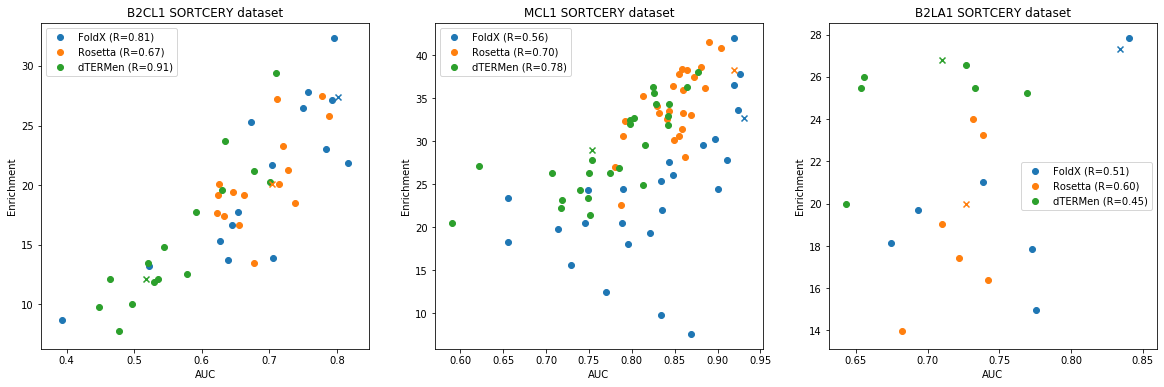

In [218]:
figsize(20,6)
plt.figure(1)
for recep in Receps:
    AUCsubdf = ModAUCDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
    CORsubdf = ModEnrDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
    plt.subplot(1,3,Receps.index(recep)+1)
    for (mod,name,i) in zip(ModToRun,ModToRunName,range(len(ModToRun))):
        scor = np.corrcoef(AUCsubdf[mod],CORsubdf[mod])[0][1]
        plt.scatter(AUCsubdf[mod],CORsubdf[mod],label=name + " (R=%.2f)" % scor,c=new_colors[i])
        #plt.axhline(np.mean(CORsubdf[mod]))
        #plt.axvline(np.mean(AUCsubdf[mod]))
        print(recep,mod,np.mean(CORsubdf[mod]),np.mean(AUCsubdf[mod]))
    plt.legend(loc=0)
    AUCsubdf = ModAUCDF.filter(regex=recep+".*"+"MIN",axis=0)
    CORsubdf = ModEnrDF.filter(regex=recep+".*"+"MIN",axis=0)
    for (mod,name,i) in zip(ModToRun,ModToRunName,range(len(ModToRun))):
        plt.scatter(AUCsubdf[mod],CORsubdf[mod],marker="x",c=new_colors[i])
        print(recep,mod+"_MIN",np.mean(CORsubdf[mod]),np.mean(AUCsubdf[mod]))
        
    plt.title(recep+" SORTCERY dataset")
   
    plt.xlabel("AUC")
    plt.ylabel("Enrichment")
plt.show()

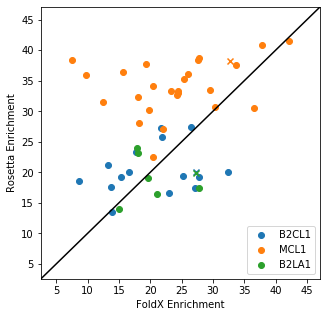

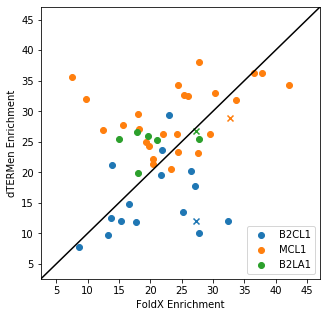

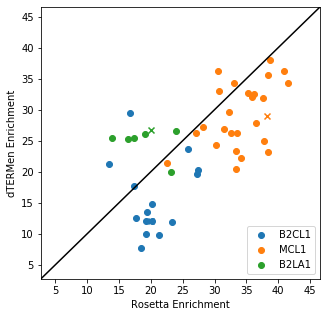

In [219]:
#Compare AUC
figsize(5,5)
for i in range(0,len(ModToRun)):
    for j in range(i+1,len(ModToRun)):
        alld = []
        allL = []
        for k in range(len(Receps)):
            recep = Receps[k]
            #AUCsubdf = ModEnrDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
            AUCsubdf = ModEnrDF.filter(regex=recep+"_HUMAN_\d+",axis=0)
            Leg = plt.scatter(AUCsubdf[ModToRun[i]],AUCsubdf[ModToRun[j]],label=recep,c=new_colors[k])
            allL.append(Leg)
            alld += list(AUCsubdf[ModToRun[i]])
            alld += list(AUCsubdf[ModToRun[j]])
            
            AUCsubdf = ModEnrDF.filter(regex=recep+".*"+"MIN",axis=0)
            plt.scatter(AUCsubdf[ModToRun[i]],AUCsubdf[ModToRun[j]],marker="x",c=new_colors[k])
        plt.xlabel("%s Enrichment" % (ModToRunName[i]))
        plt.ylabel("%s Enrichment" % (ModToRunName[j]))
        
        minv = np.min(alld)-5
        maxv = np.max(alld)+5
        plt.xlim([minv,maxv])
        plt.ylim([minv,maxv])
        plt.plot([minv,maxv],[minv,maxv],c="black")
        plt.legend(handles=allL,loc=4)
        plt.show()

In [220]:
ToTest = ModEnrDF
ToTest = ModAUCDF
#ToTest = ModCorDF
for k in range(len(Receps)):
    recep = Receps[k]
    AUCsubdf = ToTest.filter(regex=recep+"_HUMAN_\d+",axis=0)
    print(recep)
    print(AUCsubdf[ModToRun].idxmax(axis=1).value_counts())
    print()
print("ALL")
print(ToTest[ModToRun].idxmax(axis=1).value_counts())
print()

B2CL1
FoldX                              8
RosettabetaInterfacedGseparated    7
dtype: int64

MCL1
RosettabetaInterfacedGseparated    13
FoldX                              11
dTERMenC35                          1
dtype: int64

B2LA1
FoldX                              3
RosettabetaInterfacedGseparated    2
dTERMenC35                         1
dtype: int64

ALL
FoldX                              25
RosettabetaInterfacedGseparated    22
dTERMenC35                          2
dtype: int64



In [221]:
#Relation between crystal resolution and performance

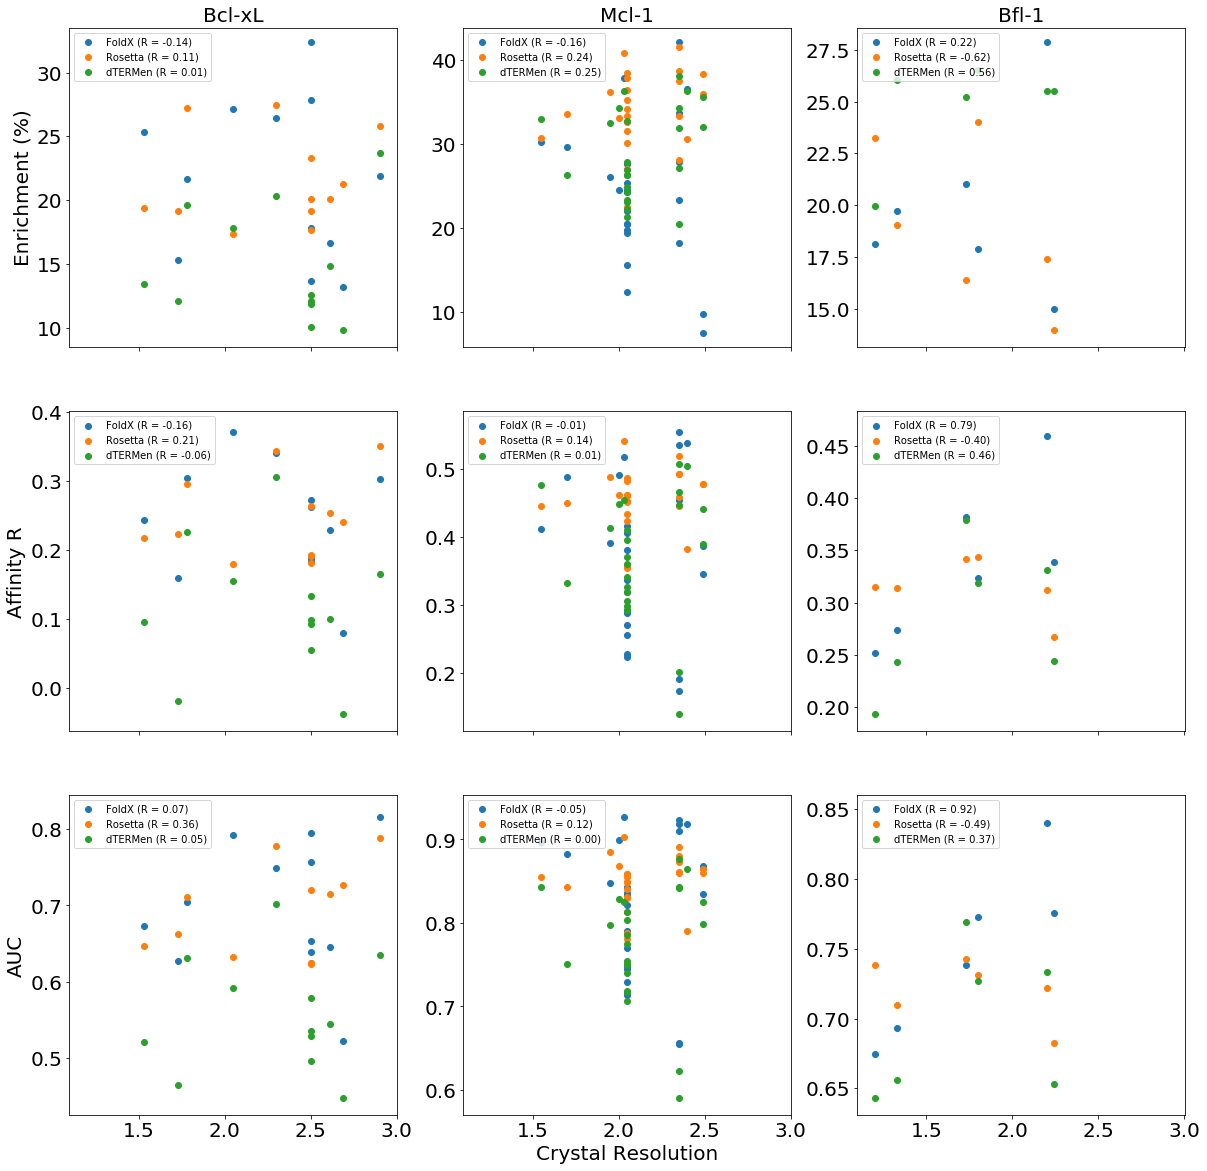

In [222]:
figsize(20,20)
fig, axes = plt.subplots(3, 3,sharex=True)
AllTest = ["Enrich_","Cor_","AUC_"]
for (test,testname) in zip(AllTest,["Enrichment (%)","Affinity R","AUC"]):
    for (recep,rname) in zip(Receps,["Bcl-xL","Mcl-1","Bfl-1"]):
        subdf = AllConcatDF[AllConcatDF["Resolution"] > 0].filter(regex=recep,axis=0)
        naxes = axes[AllTest.index(test),Receps.index(recep)]
        for (t,n) in zip(ModToRun,ModToRunName):
            k = test+t
            res = subdf["Resolution"]
            perf = subdf[k]
            lab = "%s (R = %.2f)" % (n,np.corrcoef(res,perf)[0][1])
            naxes.scatter(res,perf,label=lab)
        naxes.legend(loc=2)
        if test == "Enrich_":
            naxes.set_title(rname,size=20)
        if (rname == "Mcl-1") and (test == "AUC_"):
            naxes.set_xlabel("Crystal Resolution",size=20)
        if rname == "Bcl-xL":
            naxes.set_ylabel(testname,size=20)
        
        naxes.tick_params(labelsize=20)
        #naxes.show()
plt.savefig(f"../Figures/Supp_perf_vs_res_{FILE_SUFFIX}.tiff",format="TIFF",dpi=75)
#AllConcatDF["Resolution"]

In [223]:
# #New name
# NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]
# # NameTest = ["MCL1_SORTCERY"]

# terminatorPreds = []
# terminatorExps = []
# pdbsTest = []

# for bench in NameTest:
#     print(bench)
#     ExpRec = bench.split("_")[0]
#     #Get bench
#     OnlyBench = PepBindEnerDF.dropna(subset=[bench])
    
#     # #Get Binary
#     # binary_bench = "binary_"+bench
#     # BinaryOnlyBench = PepBindEnerDF.dropna(subset=[binary_bench])

#     Preds = []
#     Exps = []

#     for template in sorted(list(PepBindEnerDF.columns)):
#         if template == bench:continue
#         #Need to be same receptor
#         TempRec = template.split("_")[0]
#         if TempRec != ExpRec:
#             continue
            
#         #Get PDB and model name
#         sp = template.split("_")
#         mod = sp[-1]
#         pdb = "_".join(sp[:4])
#         if "MIN" in template:
#             pdb = "_".join(sp[:3])
        
#         if mod != "dTERMenC35":
#             continue

#         #Get data
#         # subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
#         subdf = OnlyBench.dropna(subset=[template]).sort_index()
#         Pred = subdf[template].values
#         Exp = subdf[bench].values
#         cor =  np.corrcoef(Pred,Exp)[0][1]
#         print(template, cor)

#         Preds.extend(Pred)
#         Exps.extend(Exp)

#         terminatorPreds.append(Pred)
#         terminatorExps.append(Exp)
#         pdbsTest.append(pdb)


#         # plt.scatter(Pred, Exp)
#         # plt.title("{}, TERMless TERMinator, {}".format(pdb,round(cor,3)))
#         # plt.xlabel("Predicted Energy")
#         # plt.ylabel("Experimental Energy")
#         # plt.show()
    
#     # terminatorPreds.append(Preds)
#     # terminatorExps.append(Exps)


In [224]:
# #New name
# NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]
# # NameTest = ["MCL1_SORTCERY"]

# terminatorPreds = []
# terminatorExps = []
# pdbsTest = []

# for bench in NameTest:
#     print(bench)
#     ExpRec = bench.split("_")[0]
#     #Get bench
#     OnlyBench = PepBindEnerDF.dropna(subset=[bench])
    
#     # #Get Binary
#     # binary_bench = "binary_"+bench
#     # BinaryOnlyBench = PepBindEnerDF.dropna(subset=[binary_bench])

#     Preds = []
#     Exps = []

#     count = 0
#     for template in sorted(list(PepBindEnerDF.columns)):
#         if template == bench:continue
#         #Need to be same receptor
#         TempRec = template.split("_")[0]
#         if TempRec != ExpRec:
#             continue
            
#         #Get PDB and model name
#         sp = template.split("_")
#         mod = sp[-1]
#         pdb = "_".join(sp[:4])
#         if "MIN" in template:
#             pdb = "_".join(sp[:3])
        
#         if mod != "dTERMenC35":
#             continue
        
#         count += 1
#         if count == 3:
#             break

#         #Get data
#         # subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
#         subdf = OnlyBench.dropna(subset=[template]).sort_index()
#         Pred = subdf[template].values
#         Exp = subdf[bench].values
#         cor =  np.corrcoef(Pred,Exp)[0][1]
#         print(template, cor)

#         Preds.extend(Pred)
#         Exps.extend(Exp)

#         terminatorPreds.append(Pred)
#         terminatorExps.append(Exp)
#         pdbsTest.append(pdb)


#         plt.scatter(Pred, Exp, s=1)
#         plt.title("{}, TERMless TERMinator, {}".format(pdb,round(cor,3)))
#         plt.xlabel("Predicted Energy")
#         plt.ylabel("Experimental Energy")
#         plt.show()
    
#     # terminatorPreds.append(Preds)
#     # terminatorExps.append(Exps)
